# Titanic Kaggle Competition
This is my second attempt at the Titanic Kaggle competition. I have used a lot of content that I initially wrote for my [first notebook](https://www.kaggle.com/thomaswoolley/random-forest-titanic-beginners-0-76-score). In this notebook I try to improve my score by doing more feature engineering and by using a Grid Search to tune the hyperparameters of my models. I also try using the k-Nearest-Neighbours classifier and a Random Forest model.

If this notebook is helpful for you, please give it an upvote! Enjoy!

This notebook is available on kaggle [here](https://www.kaggle.com/thomaswoolley/rf-and-k-nn-titanic-0-79-score) and GitHub [here](https://github.com/Woolley12345/kaggle-competitions).

# 1. **Loading Modules and Data**

We have to import modules and the data before we can do any analysis.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plottting
import seaborn as sns # more plotting

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


Now let's load in the data using pandas as visualise the top of the training and testing data.

In [2]:
# Load in the test and training data and then check the top 5 rows of each
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **2. Data Exploration**
Before we start fitting models to the data, we want to understand it a bit better. This will help with debugging problems later and will also allow more bespoke models to be implemented. The easiest way to get to know the dataset that is in front of us is to play around with it.

# 2.1. Features and Missing Data
Now we want to have a look at the data and understand the information we have been given. A good way to do this is to find out how much data we have and where there is missing data (e.g. NaNs). This will help later on when we decide how to handle the missing data.

Let's start by seeing how many rows of data we have and also the features that are provided. We can then also check whether there are any NaNs in the dataframe and which features contain them.

In [4]:
# Print the features that are available in the data
print("# of training Rows = ", len(train_data))
print("# of testing Rows = ", len(test_data))
print()
print("Train Features = ", train_data.columns.values)
print("Test Features = ", test_data.columns.values)
print()

# Check which, if any, features contain NaNs and how many they contain
print("NaNs in each training Feature")
print(train_data.isnull().sum())
print()
print("NaNs in each testing Feature")
print(test_data.isnull().sum())

# of training Rows =  891
# of testing Rows =  418

Train Features =  ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
Test Features =  ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']

NaNs in each training Feature
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

NaNs in each testing Feature
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


The above output tells us that there are 891 rows of data in the training dataframe as well as the features that are provided (columns in the dataframe). The only feature that appears in the training set but not in the test set is *Survival* because this is the output we would like to predict with a model.

We can also see that the training features: *Age*, *Cabin* and *Embarked* contain NaN values. For now this is ok, but it may need to be addressed before fitting models later on. The testing features Age, Cabin and Fare also contain NaN values.

# 2.2. Feature Distributions

Now let's look at the distributions of each feature. We can do this using the .plot() and .hist() pandas methods.

Some comments about the distributions:
* It is worth noting that everyone on board had a different *Name* and that almost everyone had a different *Ticket*. Therefore, there is no point in visualising these distributions as they will just be uniform with counts of 1. 
* Furthermore, *passengerID* is simply a number assigned to each passenger and as such, the distribution does not tell us much. 
* The *Cabin* data is mainly NaNs and so plotting the distribution is not particularly useful.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:3

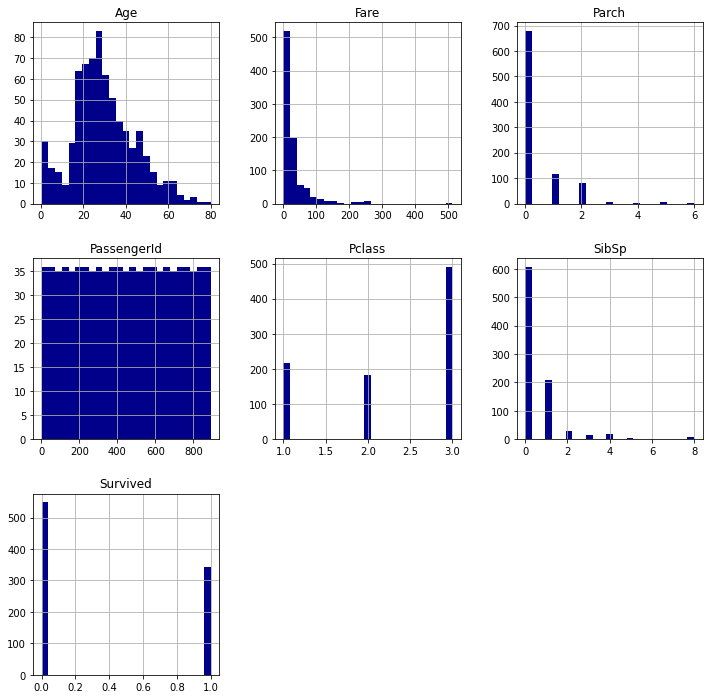

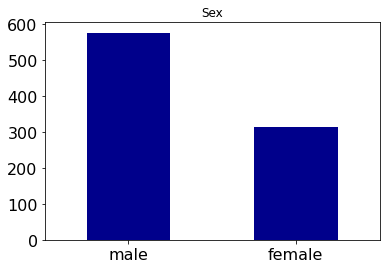

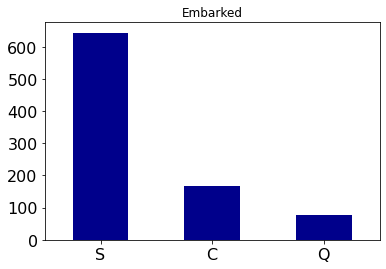

In [5]:
# Visualise the numerical values
train_data.hist(figsize=(12,12), color='darkblue', bins=25)
plt.show()

# Visualise the relevent categorical text-based features
train_data['Sex'].value_counts().plot(kind='bar', rot=0.0, fontsize=16, color='darkblue', title='Sex')
plt.show()
train_data['Embarked'].value_counts().plot(kind='bar', rot=0.0, fontsize=16, color='darkblue', title='Embarked')
plt.show()

From the above distributions we can get a feel for the data set that we are using. 

For example: 
   * The most represented *Age* range was between 20 and 40 years old
   * We can see that most people paid a *Fare* of under 20 for their tickets.
   * Most people on board had no parents or children with them 
   * Over half of the passengers were in third class
   * Most people had no siblings or spouses on board
   * Only around 40% of passengers survived (1.0)
   * Around two thirds of the passengers were male
   * The overwhelming majority of passengers *Embarked* at S


# 2.3. Feature Correlations

Now that we roughly know the distributions of each feature, we can start to see if two features are correlated with each other. Here we will not consider: *Cabin* (too much missing data), *Ticket* (not really categorical or numerical) or *Name* (all individual but covered later).

## 2.3.1. Numerical Features
By using the .corr() pandas method we can build up an idea of the relationships between each of the numerical features. This is a good sense check as to whether the data is reliable. For example, we would expect a strong correlation between *Fare* and *Class* as 1st class tickets cost more than 3rd class tickets.

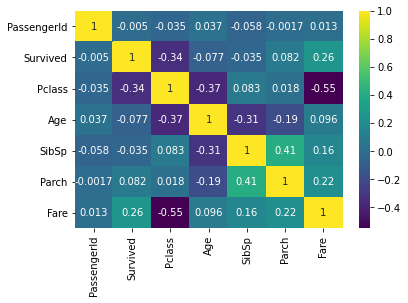

In [6]:
# Check the correlations between the non-text variables
sns.heatmap(train_data.corr(), annot = True, cmap='viridis')

By looking at the above correlation values we can see that there are some reasonable (anti-)correlations.

These include:
* *Fare* and *Class* (this makes sense because 1st class tickets are more expensive just as we predicted)
* *Survival* and *Class* (this could be interesting)
* *Survival* and *Fare* (closely related to *Survival* and *Class* correlation)
* *Class* and *Age* (this makes sense because older passengers likely have more money and are therefore more likely to have 1st or 2nd class tickets)
* *Age* and *Siblings / Spouses aboard*
* *Age* and *Parents / Childern aboard*
* *Siblings / Spouses aboard* and *Parents / Children aboard*
* *Fare* and *Siblings / Spouses aboard*
* *Fare* and *Parents / Children aboard*


There may also be some correlations between the non-numerical values, so let's check some of these.

## 2.3.2. Text-Based Features
Let's consider the categorical text-based features *Embarked* and *Sex*.

### 2.3.2.1. Embarked

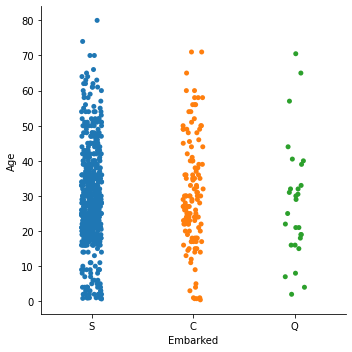

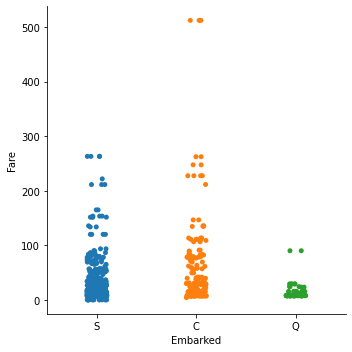

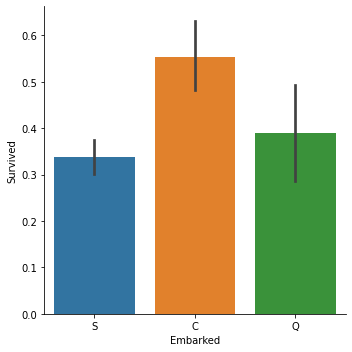

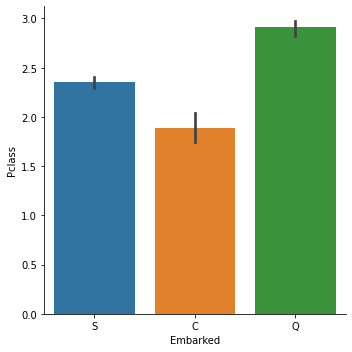

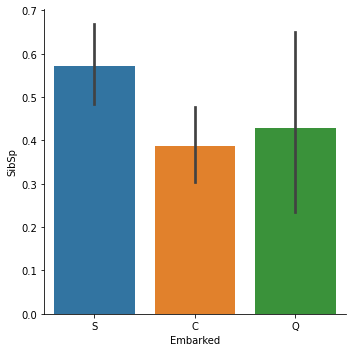

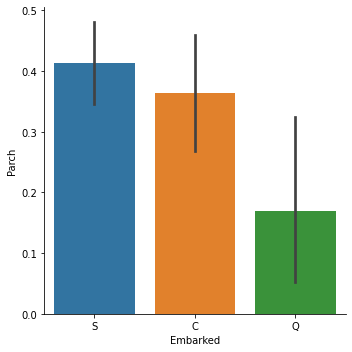

In [7]:
# Make a list of the continuous and categorical features to plot
continuous_keys = ['Age', 'Fare']
categorical_keys = ['Survived', 'Pclass', 'SibSp', 'Parch']

# Iterate through each feature and plot
for i in continuous_keys:
    sns.catplot(x = 'Embarked',y=i, data = train_data)
for i in categorical_keys:
    sns.catplot(x = 'Embarked',y=i, kind='bar', data = train_data)

### 2.3.2.2. Sex

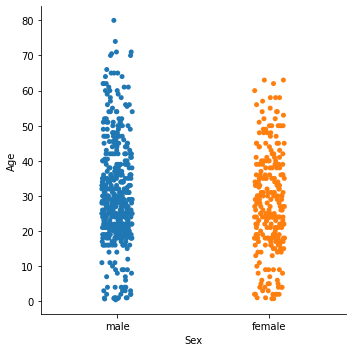

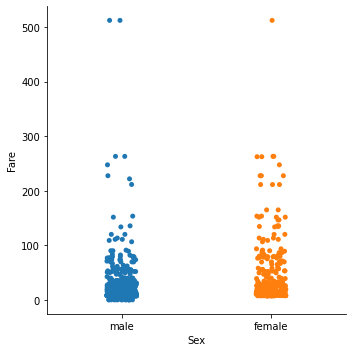

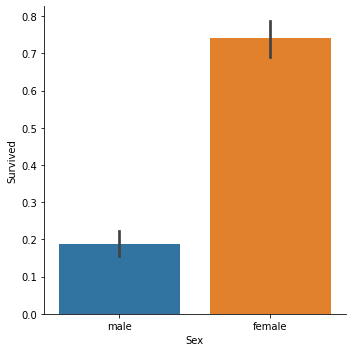

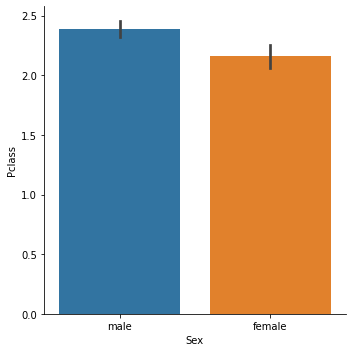

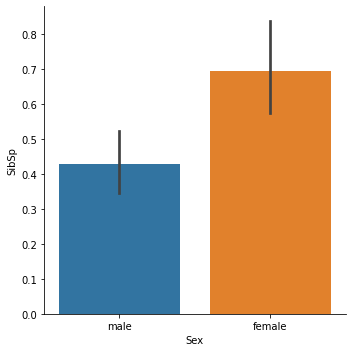

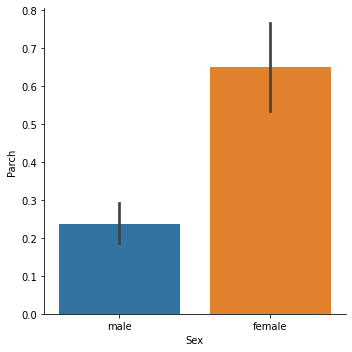

In [8]:
# Now repeat the above for the Sex feature
for i in continuous_keys:
    sns.catplot(x = 'Sex',y=i, data = train_data)
for i in categorical_keys:
    sns.catplot(x = 'Sex',y=i, kind='bar', data = train_data)

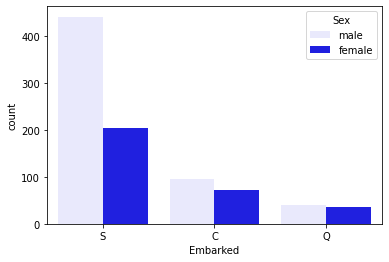

In [9]:
# Just to check Embarked against Sex
sns.countplot(x = 'Embarked', data = train_data, hue = 'Sex', color = 'blue')

Now these plots above give us some more information about the *Sex* and *Embarked* features. This could be useful later in our analysis.

# 3. Feature Engineering
Now that we understand a bit about our dataset, we can start getting ready to apply some models to it. In order to this, we should try to make the features more "model friendly". This includes filling in values that are missing and removing some data.




# 3.1. Removing Unfillable Values
As there are so many missing values for the *Cabin* feature, we should just remove this feature altogether. It would be extremely difficult to fill these values in and there would likely be a lot of errors introduced. We will also drop the *Ticket* feature.




In [10]:
# Drop the Cabin feature from the dataset
train_data.drop(columns='Cabin', inplace=True)

# Drop Ticket feature
train_data.drop(columns='Ticket', inplace=True)

Let's also define a function for removing outliers that will be used later on. I have based this outlier code on some of the code in: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [11]:
from collections import Counter

def detect_outliers(df,n,features):

    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1st quartile (25%)
        Q3 = np.percentile(df[col],75) # 3rd quartile (75%)
        IQR = Q3 - Q1 # Interquartile range (IQR)
        outlier_step = 1.5 * IQR # outlier step
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# 3.2. Filling in Missing Values
**3.2.1. Embarked**

We first need to fill in the 2 missing *Embarked* values. As the overwhelming majority of people embarked at "S" we are going to assume that these two missing values are "S". We can fill these in as shown below.

In [12]:
# Fill in the missing Embarked information
train_data['Embarked'].fillna('S', inplace=True)

**3.2.2. Using the Mean for Age**

Let's calculate the mean of the *Age* feature and use this to fill in the missing values. As *Age* is strongly correlated with *Pclass*, let's use *Pclass* in order to fill the *Age* values.

In [13]:
# Calculate the mean of the Age feature
meanAges = train_data.groupby(['Pclass'])['Age'].mean()
print(meanAges)

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64


Now we just have to fill in the missing *Age* values

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


Text(0.5, 0, 'Age')

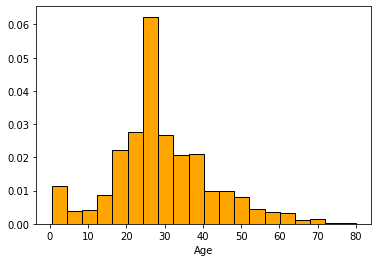

In [14]:
# Fill in the missing age values
for i in range(3):
    train_data.loc[train_data['Pclass']==int(i+1), 'Age'] = train_data.loc[train_data['Pclass']==int(i+1), 'Age'].fillna(meanAges.values[i])

# Check everything has been filled as expected
print(train_data.isnull().sum())

# And plot to check the values have been filled as expected
plt.figure()
plt.hist(train_data['Age'].values, bins=20, color="orange", ec='black', label="New Total Age Dist", density=True)
plt.xlabel("Age")

# 3.3. Expanding Existing Features
Here we will try to adjust some of the features to provide better insights into the situation and improve the model.

**3.3.1. Gender Feature**

First let's expand this feature to include children as well.

In [15]:
# Create a new column in the data frame
train_data['newGender'] = train_data['Sex']

# Find all the children
train_data.loc[train_data['Age']<16., 'newGender'] = 'child'

# Drop the Sex feature as it is not needed anymore
train_data.drop(columns='Sex', inplace=True)

print(train_data.head(8))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   

                                                Name       Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.00000      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.00000      1      0   
2                             Heikkinen, Miss. Laina  26.00000      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.00000      1      0   
4                           Allen, Mr. William Henry  35.00000      0      0   
5                                   Moran, Mr. James  25.14062      0      0   
6                            McCarthy, Mr. Timothy J  54.00000      0      0   
7                     Palsson, Mast

**3.3.2. Name Feature**

Now let's get the title of the each person and feed this into the model. Some of this code was from: https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83

In [16]:
train_data['Title'] = train_data['Name']

# Extracting Title
for name_string in train_data['Name']:
    train_data['Title'] = train_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing some titles using a mapping
mapping = {'Mlle': 'Miss', 'Major': 'Rare', 'Col': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Mme': 'Miss',
          'Jonkheer': 'Rare', 'Lady': 'Rare', 'Capt': 'Rare', 'Countess': 'Rare', 'Ms': 'Miss', 'Dona': 'Mrs', 'Rev': 'Rare'}
train_data.replace({'Title': mapping}, inplace=True)

# Remove the Name column
train_data.drop(columns='Name', inplace=True)

**3.3.3. Family Size Feature**

Now let's work out the size of families on board

In [17]:
# Calculate the number if members in the family (excluding the individual)
train_data['familyNumber'] = train_data['SibSp'] + train_data['Parch']
print(train_data.head(8))

# Detect outliers from Age, familyNumber and Fare
Outliers_to_drop = detect_outliers(train_data,1,["Age","familyNumber","Fare"])
train_data = train_data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

# Create the familySize feature
train_data['familySize'] = np.nan

# Fill it with text-based categorical data
train_data.loc[train_data['familyNumber']==0, 'familySize'] = 'alone'
train_data.loc[train_data['familyNumber']==1, 'familySize'] = 'couple'
train_data.loc[train_data['familyNumber']==2, 'familySize'] = 'small'
train_data.loc[train_data['familyNumber']==3, 'familySize'] = 'medium'
train_data.loc[train_data['familyNumber']>=4, 'familySize'] = 'large'

# Drop the columns that are no longer needed
train_data.drop(columns=['familyNumber', 'SibSp', 'Parch'], inplace=True)

   PassengerId  Survived  Pclass       Age  SibSp  Parch     Fare Embarked  \
0            1         0       3  22.00000      1      0   7.2500        S   
1            2         1       1  38.00000      1      0  71.2833        C   
2            3         1       3  26.00000      0      0   7.9250        S   
3            4         1       1  35.00000      1      0  53.1000        S   
4            5         0       3  35.00000      0      0   8.0500        S   
5            6         0       3  25.14062      0      0   8.4583        Q   
6            7         0       1  54.00000      0      0  51.8625        S   
7            8         0       3   2.00000      3      1  21.0750        S   

  newGender   Title  familyNumber  
0      male      Mr             1  
1    female     Mrs             1  
2    female    Miss             0  
3    female     Mrs             1  
4      male      Mr             0  
5      male      Mr             0  
6      male      Mr             0  
7     chi

# 3.4. Handling Categorical Text Data
It is important to convert text labels into something more understandable for the model. To do this with category based text data we can use one hot encoding as below.

In [18]:
# Turn Pclass into a text-based categorical features
train_data['newPclass'] = np.nan
train_data.loc[train_data['Pclass']==1, 'newPclass'] = 'first'
train_data.loc[train_data['Pclass']==2, 'newPclass'] = 'second'
train_data.loc[train_data['Pclass']==3, 'newPclass'] = 'third'
train_data.drop(columns='Pclass', inplace=True)

# Specify which columns to one hot encode
columns = ['newGender', 'Embarked', 'Title', 'familySize', 'newPclass']

# Do the encoding for the two dataframes we are comapring
one_hot = pd.get_dummies(train_data.loc[:, columns], drop_first=True)
train_data.drop(columns=columns, inplace=True)
train_data = train_data.join(one_hot)

# Print the output to check it has done what we wanted
print(train_data.head(2))
print(train_data.columns.values)

   PassengerId  Survived   Age     Fare  newGender_female  newGender_male  \
0            1         0  22.0   7.2500                 0               1   
1            2         1  38.0  71.2833                 1               0   

   Embarked_Q  Embarked_S  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0           0           1             0           0         1          0   
1           0           0             0           0         0          1   

   Title_Rare  familySize_couple  familySize_large  familySize_medium  \
0           0                  1                 0                  0   
1           0                  1                 0                  0   

   familySize_small  newPclass_second  newPclass_third  
0                 0                 0                1  
1                 0                 0                0  
['PassengerId' 'Survived' 'Age' 'Fare' 'newGender_female' 'newGender_male'
 'Embarked_Q' 'Embarked_S' 'Title_Master' 'Title_Miss' 'Title_Mr'
 'Title

# 4. Fitting Models

As the aim of this task is to predict whether passengers survived or not, it is a classification task. For this we can used a variety of classification models to predict the outcome. It is also worth noting that the success of this task is determined by the accuracy (the percentage of passenger outcomes successfully predicted). 


**4.1. Importing**

In [19]:
# Import some required modules for the fitting
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

**4.2. k-Nearest Neighbours**

One model that we can fit to classify our data is called k-NN. We can fit it and check that accuracy as shown below.

For k-NN, the features must be scaled first. This is not necessary for RF though.

In [20]:
# Fit the scaler on all the training data
trainScaler = StandardScaler()
trainScaler.fit(train_data.drop(['Survived', 'PassengerId'], axis = 1))

# Scale data
X_train_scaled = trainScaler.transform(train_data.drop(['Survived', 'PassengerId'], axis = 1))

# Split the training data into X and y data
X_train = train_data.drop(['Survived', 'PassengerId'], axis = 1)
y_train = train_data['Survived']

In [21]:
# Try to improve the KNN results with hyperparameter tuning with grid search
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
                }
KNN_CV = GridSearchCV(estimator = KNeighborsClassifier(), param_grid=grid_params, cv = 3)
KNN_CV.fit(X_train_scaled, y_train)

# Print the best score
print(KNN_CV.best_score_)

# Get the parameters from the best fit
weights = KNN_CV.best_params_.get('weights')
n = KNN_CV.best_params_.get('n_neighbors')
metric = KNN_CV.best_params_.get('metric')

# Train the classifier on all the data for predicting the test data (use best hyperparams)
bestKNN = KNeighborsClassifier(n_neighbors=n, weights=weights, metric=metric)
bestKNN.fit(X_train_scaled, y_train)

0.8279307638087915


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

**4.3. Random Forest**

Now let's fit a Random Forest Model to the data.

In [22]:
# Search for the optimal hyperparameters for RF
param_grid = { 
    'criterion' : ['gini'],
    'n_estimators': [70, 80, 90, 100],
    'max_features': ['auto', 'log2'],
    'max_depth' : [5, 7, 9, 11]    
                }
randomForest_CV = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 3)
randomForest_CV.fit(X_train, y_train)
#print(randomForest_CV.best_params_)

# Print the best score
print(randomForest_CV.best_score_)

# Get the parameters from the best fit
criterion = randomForest_CV.best_params_.get('criterion')
nRF = randomForest_CV.best_params_.get('n_estimators')
max_features = randomForest_CV.best_params_.get('max_features')
max_depth = randomForest_CV.best_params_.get('max_depth')

# Train the classifier on all the data for predicting the test data (use best hyperparams)
bestRF = RandomForestClassifier(n_estimators=1000, max_depth=max_depth, max_features=max_features, criterion=criterion)
bestRF.fit(X_train, y_train)

0.8337017813661411


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Both the RF and k-NN models give us over **83% accuracy** on the training data. Now we can use the best parameters to fit the models and predict the test data outcomes.


# 5. Generating a Submission File
Now we just need to generate a submission file for the competition using our trained model. This can be done as outlined below (Note that we could have done all of the processing of the test data with the training data earlier on but have kept it separate for clarity here).

**5.1 Fill the missing Values** 

In [23]:
# Fill the missing Age values in the test data set with the averages found from the training data
for i in range(3):
    test_data.loc[test_data['Pclass']==int(i+1), 'Age'] = test_data.loc[test_data['Pclass']==int(i+1), 'Age'].fillna(meanAges.values[i])

# Fill the missing Fare values in the test data set
meanFare = test_data['Fare'].median()
test_data['Fare'].fillna(meanFare, inplace=True)

**5.2 Expand some of the Test Features**

In [24]:
# Expand the gender feature in the test set
test_data['newGender'] = test_data['Sex']
test_data.loc[test_data['Age']<18., 'newGender'] = 'child'
test_data.drop(columns='Sex', inplace=True)

# Get the titles for the test set
test_data['Title'] = test_data['Name']
for name_string in test_data['Name']:
    test_data['Title'] = test_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)
mapping = {'Mlle': 'Miss', 'Major': 'Rare', 'Col': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Mme': 'Miss',
          'Jonkheer': 'Rare', 'Lady': 'Rare', 'Capt': 'Rare', 'Countess': 'Rare', 'Ms': 'Miss', 'Dona': 'Mrs', 'Rev': 'Rare'}
test_data.replace({'Title': mapping}, inplace=True)
test_data.drop(columns='Name', inplace=True)

# Expand the family feature
test_data['familyNumber'] = test_data['SibSp'] + test_data['Parch']
test_data['familySize'] = np.nan
test_data.loc[test_data['familyNumber']==0, 'familySize'] = 'alone'
test_data.loc[test_data['familyNumber']==1, 'familySize'] = 'couple'
test_data.loc[test_data['familyNumber']==2, 'familySize'] = 'small'
test_data.loc[test_data['familyNumber']==3, 'familySize'] = 'medium'
test_data.loc[test_data['familyNumber']>=4, 'familySize'] = 'large'
test_data.drop(columns=['familyNumber', 'SibSp', 'Parch'], inplace=True)

# Create the new Pclass feature
test_data['newPclass'] = np.nan
test_data.loc[test_data['Pclass']==1, 'newPclass'] = 'first'
test_data.loc[test_data['Pclass']==2, 'newPclass'] = 'second'
test_data.loc[test_data['Pclass']==3, 'newPclass'] = 'third'
test_data.drop(columns='Pclass', inplace=True)

In [25]:
# Drop the features that we have not trained on
test_data.drop(columns=['Cabin', 'Ticket'], inplace=True)

# One hot encode the test data features
one_hot = pd.get_dummies(test_data.loc[:, columns], drop_first=True)
test_data.drop(columns=columns, inplace=True)
test_data = test_data.join(one_hot)

# Check all the NaNs have been dealt with
print("NaNs in each testing Feature")
print(test_data.isnull().sum())

NaNs in each testing Feature
PassengerId          0
Age                  0
Fare                 0
newGender_female     0
newGender_male       0
Embarked_Q           0
Embarked_S           0
Title_Master         0
Title_Miss           0
Title_Mr             0
Title_Mrs            0
Title_Rare           0
familySize_couple    0
familySize_large     0
familySize_medium    0
familySize_small     0
newPclass_second     0
newPclass_third      0
dtype: int64


**5.3. Predictions!**

In [26]:
# Scale the test data by the same amount as the train data
X_test_scaled = trainScaler.transform(test_data.drop(['PassengerId'], axis = 1))
X_test = test_data.drop(columns='PassengerId')

# Use the models to predict the output of the test data
testPredictionsKNN = bestKNN.predict(X_test_scaled)
testPredictionsRF = bestRF.predict(X_test)

# Save the outputs to csv files
outputKNN = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': testPredictionsKNN})
outputKNN.to_csv('my_submissionKNN.csv', index=False)
outputRF = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': testPredictionsRF})
outputRF.to_csv('my_submissionRF.csv', index=False)

Now all we have to do is submit the outputs to the competition. The Random Forest Model gives a higher test score than the k-NN model. **If you've got this far, please give my notebook an upvote! It really helps!**

## Just trying some other models here quickly...

In [27]:
from sklearn.ensemble import GradientBoostingClassifier


param_grid = { 
    'learning_rate' : [0.1, 0.2],
    'n_estimators': [90, 100, 110],
    'loss': ['deviance', 'exponential']    
                }
gradBoost_CV = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv = 3)
gradBoost_CV.fit(X_train, y_train)
#print(randomForest_CV.best_params_)

# Print the best score
print(gradBoost_CV.best_score_)

# Get the parameters from the best fit
learning = gradBoost_CV.best_params_.get('learning_rate')
nGB = gradBoost_CV.best_params_.get('n_estimators')
loss = gradBoost_CV.best_params_.get('loss')

# Train the classifier on all the data for predicting the test data (use best hyperparams)
bestGB = GradientBoostingClassifier(learning_rate=learning, n_estimators=nGB, loss=loss)
bestGB.fit(X_train, y_train)

testPredictionsGB = bestGB.predict(X_test)

outputGB = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': testPredictionsGB})
outputGB.to_csv('my_submissionGB.csv', index=False)

0.8406542355504293


In [28]:
from xgboost import XGBClassifier

param_grid = { 
    'learning_rate' : [0.1, 0.2],
    'max_depth': [3, 5, 7],   
                }
xgBoost_CV = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, cv = 3)
xgBoost_CV.fit(X_train, y_train)
#print(randomForest_CV.best_params_)

# Print the best score
print(xgBoost_CV.best_score_)


# Get the parameters from the best fit
learning = xgBoost_CV.best_params_.get('learning_rate')
depth = xgBoost_CV.best_params_.get('max_depth')


# Train the classifier on all the data for predicting the test data (use best hyperparams)
bestXGB = XGBClassifier(learning_rate=learning, max_depth=depth)
print(bestXGB)
bestXGB.fit(X_train, y_train)

testPredictionsXGB = bestXGB.predict(X_test)

outputGB = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': testPredictionsXGB})
outputGB.to_csv('my_submissionXGB.csv', index=False)

0.8348591887735486
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)
